[1] "merge_train_and_test_dataframe"

[1] "merge_train_and_test_dataframe"

[1] "drop_variable_before_preparation"

[1] "drop_variable_before_preparation"

[1] "clean_data"

[1] "clean_data"

[1] "numerical_feature_logical_incl_hidden_num"

[1] "numerical_feature_logical_incl_hidden_num"

[1] "numerical_feature_logical"

[1] "numerical_feature_logical"

[1] "extract_numerical_features"

[1] "extract_numerical_features"

[1] "extract_non_numerical_features"

[1] "extract_non_numerical_features"

[1] "encode_labels_in_numeric_format"

[1] "encode_labels_in_numeric_format"

[1] "one_hot_encoder"

[1] "one_hot_encoder"

[1] "feature_mapping_to_numerical_values"

[1] "feature_mapping_to_numerical_values"

[1] "feature_names_num_drop"

[1] "feature_names_num_drop"

[1] "feature_names_num"

[1] "feature_names_num"

[1] "drop_features_num"

[1] "drop_features_num"

[1] "get_is_one_hot_encoder"

[1] "get_is_one_hot_encoder"

[1] "set_is_one_hot_encoder"

[1] "set_is_one_hot_encoder"

[1] "skew_correction"

[1] "skew_correction"

[1] "skew_correction"

[1] "feature_engineering"

[1] "feature_engineering"

[1] "feature_scaling"

[1] "feature_scaling"

[1] "plot_histogram"

[1] "plot_histogram"

[1] "plot_function"

[1] "plot_function"

[1] "plot_density"

[1] "plot_density"

[1] "extract_numerical_value_from_character"

[1] "extract_numerical_value_from_character"

[1] "drop_features"

[1] "drop_features"

[1] "prepare_data"

[1] "prepare_data"


 iter imp variable
  1   1  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  1   2  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  1   3  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  1   4  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  1   5  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  2   1  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  2   2  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  2   3  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  2   4  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  2   5  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  3   1  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  3   2  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  3   3  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  3   4  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  3   5  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  4   1  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  4   2  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  4   3  Age  Fare  EmbarkedC  EmbarkedQ  EmbarkedS
  4   4  Age  Fare  EmbarkedC  EmbarkedQ  Em

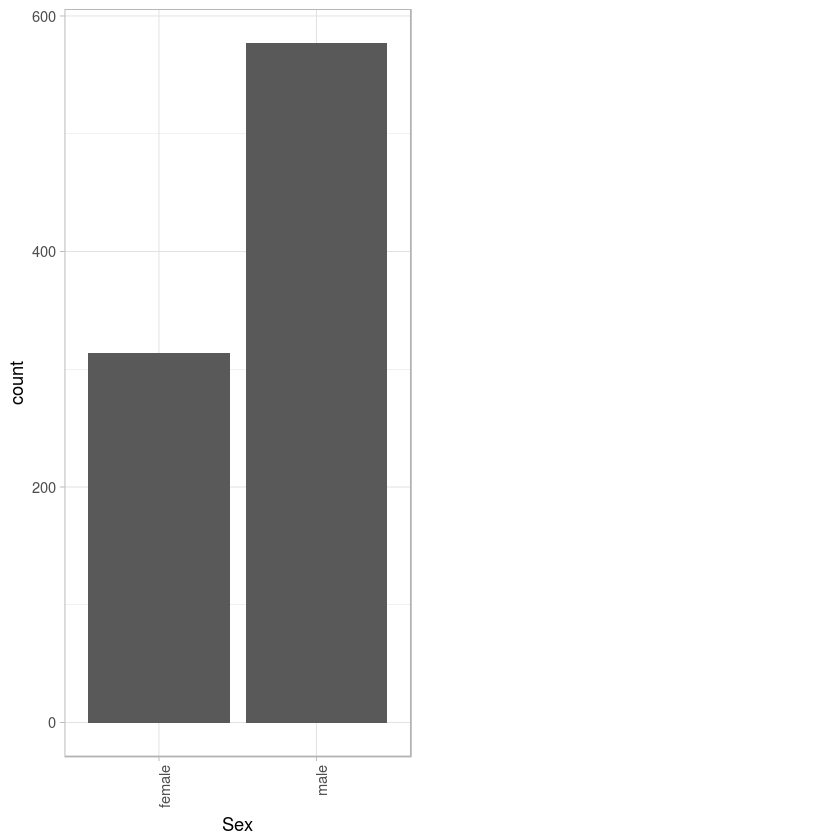

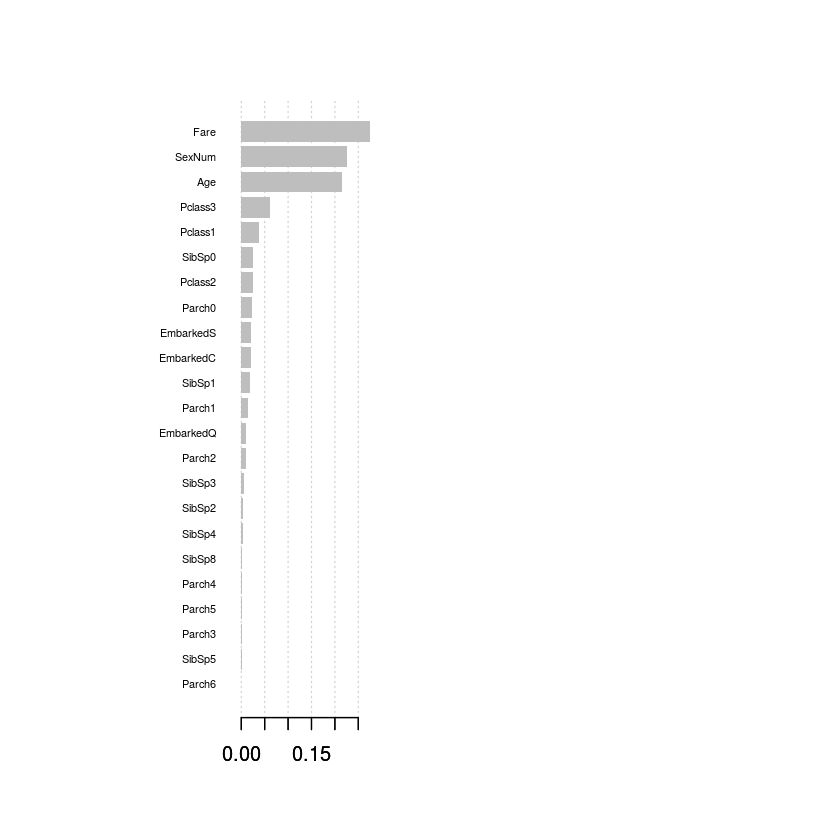

In [3]:
# Titanic survival classification problem

library(data.table)
library(xgboost)
library(Metrics)
library(Matrix)
library(mice)
library(dplyr)
library('ggplot2')
library('ggthemes')
library('scales')
library(bit64)  # may be needed for fread() for bit64::integer64 type properly displayed
library(moments)  # imports skewness
library(caret)
library(car)
library(stringr)
library(gridExtra)
library(cowplot)
library(lattice)
library(readr)
# library(Hmisc)  # not working
# library(Formula)
# library(VIM)

Titanic <- setClass(
  # Set name of class
  "Titanic",
  
  # Define slots
  slots = c(
    df = "data.frame",
    df_test = "data.frame",
    # df_train_test_merged = "numeric"
    numerical_feature_names = "character",
    non_numerical_feature_names = "character",
    feature_names_num = "character",
    feature_names_num_drop = "character",
    is_one_hot_encoder = "logical",
    is_with_log1p_SalePrice = "logical"
    
  ),
  
  # Set default values
  prototype=list(
    df = fread('/home/mizio/Documents/Kaggle/Titanic/train.csv', showProgress = T, data.table = FALSE),
    df_test = fread('/home/mizio/Documents/Kaggle/Titanic/test.csv', showProgress = T, data.table = FALSE),
    numerical_feature_names = c(),
    non_numerical_feature_names = c(),
    feature_names_num = c(),
    feature_names_num_drop = c(),
    is_one_hot_encoder = F,
    is_with_log1p_SalePrice = F
  )
)

setGeneric(name="merge_train_and_test_dataframe",
           def=function(theObject, df, df_test)
           {
             standardGeneric("merge_train_and_test_dataframe")
           }
)

setMethod(f="merge_train_and_test_dataframe",
          signature="Titanic",
          definition=function(theObject, df, df_test)
          {
            # Remove classLabel (stored in y_train)
            df$Survived <- NULL
            # df_test$classLabel <- NULL
            return(rbind(df, df_test))
          }
)

setGeneric(name="drop_variable_before_preparation",
           def=function(theObject, df)
           {
             standardGeneric("drop_variable_before_preparation")
           }
)

setMethod(f="drop_variable_before_preparation",
          signature="Titanic",
          definition=function(theObject, df)
          {
            # Drop features that have certain procentage of missing values considering the training data and test, 
            # since they will undergo imputation together.
            # print(colSums(is.na(df)))
            number_of_missing_values_in_features <- colSums(is.na(df))
            features_with_many_missing_values <- character(0)
            features_in_df <- names(df)
            for(feature in features_in_df)
            {
              if(number_of_missing_values_in_features[[feature]] >= 0.3*nrow(df))  # 0.3*nrow(df))
              {
                features_with_many_missing_values <- append(features_with_many_missing_values, feature)
              }
            }
            # print(features_with_many_missing_values)
            df <- df[, !(names(df) %in% features_with_many_missing_values)]
            features_to_drop <- c("Name", "PassengerId", "Cabin", "Ticket")
            df[, features_to_drop] <- NULL
            return(df)
          }
)

setGeneric(name="clean_data",
           def=function(theObject, df)
           {
             standardGeneric("clean_data")
           }
)

setMethod(f="clean_data",
          signature="Titanic",
          definition=function(theObject, df)
          {
            if(sum(is.na(df)) > 0)
            {
              is_with_MICE <- T
              if(is_with_MICE)
              {
                # Imputation with MICE
                set.seed(0)
                df <- as.data.frame(df)
                df_imputed <- complete(mice(df))  # method='rf'))
              } else
              {
                # Remove all rows with NA values
                df_imputed <- df[complete.cases(df),]
              }
              
            }
            return(df_imputed)
          }
)

setGeneric(name="numerical_feature_logical_incl_hidden_num",
           def=function(theObject, df, numerical_features)
           {
             standardGeneric("numerical_feature_logical_incl_hidden_num")
           }
)

setMethod(f="numerical_feature_logical_incl_hidden_num",
          signature="Titanic",
          definition=function(theObject, df, numerical_features)
          {
            for(feature in rownames(numerical_features))
            {
              if(!numerical_features[feature,])
              {
                if(any(!is.na(as.numeric(unlist(strsplit(unlist(df[,feature]), "[^0-9]+"))))))
                {
                  numerical_features[feature,] = T
                }
              }
            }
            return(numerical_features)
          }
)

setGeneric(name="numerical_feature_logical",
           def=function(theObject, df)
           {
             standardGeneric("numerical_feature_logical")
           }
)

setMethod(f="numerical_feature_logical",
          signature="Titanic",
          definition=function(theObject, df)
          {
            # Numeric data types in R: 'numeric', 'integer'
            numerical_features <- data.frame(logical(dim(df)[2]), row.names = names(df))
            for(feature in rownames(numerical_features))
            {
              # if(class(df[, get(feature)]) == "numeric" || class(df[, get(feature)]) == "integer")
              if(class(df[, feature]) == "numeric" || class(df[, feature]) == "integer")
              {
                numerical_features[feature,] = T
              }
            }
            return(numerical_features)
          }
)

setGeneric(name="extract_numerical_features",
           def=function(theObject, numerical_features)
           {
             standardGeneric("extract_numerical_features")
           }
)

setMethod(f="extract_numerical_features",
          signature="Titanic",
          definition=function(theObject, numerical_features)
          {
            mask_index <- which(numerical_features$logical.dim.df..2..)
            return(rownames(numerical_features)[mask_index])
          }
)

setGeneric(name="extract_non_numerical_features",
           def=function(theObject, numerical_features)
           {
             standardGeneric("extract_non_numerical_features")
           }
)

setMethod(f="extract_non_numerical_features",
          signature="Titanic",
          definition=function(theObject, numerical_features)
          {
            mask_index <- which(numerical_features$logical.dim.df..2.. == F)
            return(rownames(numerical_features)[mask_index])
          }
)

setGeneric(name="encode_labels_in_numeric_format",
           def=function(theObject, df, feature)
           {
             standardGeneric("encode_labels_in_numeric_format")
           }
)
setMethod(f="encode_labels_in_numeric_format",
          signature="Titanic",
          definition=function(theObject, df, feature)
          {
            # Encode categorical features as integers
            feature_name_num <- paste0(feature, 'Num', collapse='')
            levels <- sort(unique(df[[feature]]))
            df[[feature_name_num]] <- as.integer(factor(df[[feature]], levels=levels))
            return(df)
          }
)

setGeneric(name="one_hot_encoder",
           def=function(theObject, df, feature)
           {
             standardGeneric("one_hot_encoder")
           }
)

setMethod(f="one_hot_encoder",
          signature="Titanic",
          definition=function(theObject, df, feature)
          {
            levels <- sort(unique(df[[feature]]))
            levels_num <- lapply(levels, function(x) paste0(feature, x, collapse=''))
            feature_num <- paste0(feature, 'Num', collapse='')
            ith <- 1
            for(level in levels_num)
            {
              df[level] <- as.integer(df[feature_num] == ith)
              ith <- ith + 1
            }
            
            # df_all_dummy <- acm.disjonctif(df[feature])
            # df[feature] <- NULL
            # df <- cbind(df, df_all_dummy)
            return(df)
            
          }
)

setGeneric(name="feature_mapping_to_numerical_values",
           def=function(theObject, df)
           {
             standardGeneric("feature_mapping_to_numerical_values")
           }
)

setMethod(f="feature_mapping_to_numerical_values",
          signature="Titanic",
          definition=function(theObject, df)
          {
            for(feature in theObject@non_numerical_feature_names)
            {
              if(feature == 'Embarked')
              {
                embarked_logical_NA <- df$Embarked == ""
                df[which(embarked_logical_NA), feature] <- NA 
                
              }
              # Check that feature var consist of more than 3 labels before dummy labels are assigned
              if(length(sort(unique(df[[feature]]))) > 2L)
              {
                df <- encode_labels_in_numeric_format(theObject, df, feature)
                
                if(theObject@is_one_hot_encoder)
                {
                  df <- one_hot_encoder(theObject, df, feature)
                }
              } else
              {
                feature_num <- paste0(feature, 'Num', collapse='')
                df[, feature_num] <- as.integer(df[, feature] == sort(unique(df[[feature]]))[1])
              }
            }
            
            for(feature in theObject@numerical_feature_names)
            {
              # Check that feature var consist of more than 3 labels but less than 10 before dummy labels are assigned
              if(length(sort(unique(df[[feature]]))) < 10L)
              {
                if(length(sort(unique(df[[feature]]))) > 2L)
                {
                  df <- encode_labels_in_numeric_format(theObject, df, feature)
                  
                  if(theObject@is_one_hot_encoder)
                  {
                    df <- one_hot_encoder(theObject, df, feature)
                  }
                } else
                {
                  feature_num <- paste0(feature, 'Num', collapse='')
                  df[, feature_num] <- as.integer(df[, feature] == sort(unique(df[[feature]]))[1])
                }
              }
            }
            
            
                        
            return(df)
          }
)

setGeneric(name="feature_names_num_drop",
           def=function(theObject, df)
           {
             standardGeneric("feature_names_num_drop")
           }
)

setMethod(f="feature_names_num_drop",
          signature="Titanic",
          definition=function(theObject, df)
          {
            feature_names_num_drop <- vector("character")
            for(feature in theObject@feature_names_num)
            {
              if(length(sort(unique(df[[feature]]))) > 2L)
              {
                feature_names_num_drop <- c(feature_names_num_drop, feature)
              }
            }
            return(feature_names_num_drop)
          }
)
    
    
setGeneric(name="feature_names_num",
           def=function(theObject, df)
           {
             standardGeneric("feature_names_num")
           }
)

setMethod(f="feature_names_num",
          signature="Titanic",
          definition=function(theObject, df)
          {
            feature_names_num <- vector("character", length=length(theObject@non_numerical_feature_names))
            ith <- 1
            for(feature in theObject@non_numerical_feature_names)
            {
              feature_name_num <- paste0(feature, 'Num', collapse='')
              feature_names_num[ith] <- feature_name_num
              ith = ith + 1
            }
            
            for(feature in theObject@numerical_feature_names)
            {
              if(length(sort(unique(df[[feature]]))) < 10L)
              {
                feature_names_num <- c(feature_names_num, paste0(feature, 'Num', collapse=''))
              }
            }
            return(feature_names_num)
          }
)

setGeneric(name="drop_features_num",
           def=function(theObject, df)
           {
             standardGeneric("drop_features_num")
           }
)

setMethod(f="drop_features_num",
          signature="Titanic",
          definition=function(theObject, df)
          {
            df <- df[, !(names(df) %in% theObject@feature_names_num_drop)]
            return(df)
          }
)

setGeneric(name="get_is_one_hot_encoder",
           def=function(theObject)
           {
             standarGeneric("get_is_one_hot_encoder")
           }
)

setMethod(f="get_is_one_hot_encoder",
          signature="Titanic",
          definition=function(theObject)
          {
            return(theObject@is_one_hot_encoder)
          }
)

setGeneric(name="set_is_one_hot_encoder",
           def=function(theObject, is_one_hot_encoder)
           {
             standarGeneric("set_is_one_hot_encoder")
           }
)

setMethod(f="set_is_one_hot_encoder",
          signature="Titanic",
          definition=function(theObject, is_one_hot_encoder)
          {
            theObject@is_one_hot_encoder <- is_one_hot_encoder
            return(theObject)
          }
)

setGeneric(name="skew_correction",
           def=function(theObject, df)
           {
             standardGeneric("skew_correction")
           }
)

setMethod(f="skew_correction",
          signature=c("Titanic", "data.frame"),
          definition=function(theObject, df)
          {
            skewed_feats <- lapply(df, function(x) skewness(x[!is.na(x)]))  # compute skewness
            skewed_feats <- skewed_feats[skewed_feats > 0.75]
            skewed_feats = names(skewed_feats)
            df[, skewed_feats] <- log1p(df[skewed_feats])
            return(df)
          }
)

setMethod(f="skew_correction",
          signature=c("Titanic", "integer"),
          definition=function(theObject, df)
          {
            # browser()
            is_skewed_feat <- skewness(df) > 0.75  # compute skewness
            if(is_skewed_feat)
            {
              df <- log1p(df)
            }
            return(df)
          }
)

setGeneric(name="feature_engineering",
           def=function(theObject, df)
           {
             standardGeneric("feature_engineering")
           }
)

setMethod(f="feature_engineering",
          signature="Titanic",
          definition=function(theObject, df)
          {
            is_skewness_correction_for_all_features <-  1
            if(is_skewness_correction_for_all_features)
            {
              # Correcting for skewness
              # Treat all numerical variables that were not one-hot encoded
              numerical_feature_names_of_non_modified_df <- theObject@numerical_feature_names
              if(!(theObject@is_one_hot_encoder))
              {
                numerical_feature_names_of_non_modified_df <- c(theObject@feature_names_num, 
                                                                numerical_feature_names_of_non_modified_df)
              }
              relevant_features <- numerical_feature_names_of_non_modified_df[(numerical_feature_names_of_non_modified_df %in% colnames(df))]
              df[, relevant_features] <- skew_correction(theObject, df[, relevant_features])
            } else
            {
              # Only scale down sale price and leave other numerical features standardized.
              if(any(names(df) %in% 'SalePrice'))
              {
                df$SalePrice <- log1p(df$SalePrice)
              }
            }
            return(df)
          }
)

setGeneric(name="feature_scaling",
           def=function(theObject, df)
           {
             standardGeneric("feature_scaling")
           }
)

setMethod(f="feature_scaling",
          signature="Titanic",
          definition=function(theObject, df)
          {
            is_scaling_for_all_features <-  1
            if(is_scaling_for_all_features)
            {
              # Correcting for skewness
              # Treat all numerical variables that were not one-hot encoded
              numerical_feature_names_of_non_modified_df <- theObject@numerical_feature_names
              if(!(theObject@is_one_hot_encoder))
              {
                numerical_feature_names_of_non_modified_df <- c(theObject@feature_names_num, 
                                                                numerical_feature_names_of_non_modified_df)
              }
              relevant_features <- numerical_feature_names_of_non_modified_df[(numerical_feature_names_of_non_modified_df %in% colnames(df))]
              df[, relevant_features] <- scale(df[, relevant_features])
            } else
            {
              # Only scale down sale price and leave other numerical features standardized.
              if(any(names(df) %in% 'SalePrice'))
              {
                df$SalePrice <- scale(df$SalePrice)
              }
            }
            return(df)
          }
)

setGeneric(name="plot_histogram",
           def=function(theObject, df, feature_col_index)
           {
             standardGeneric("plot_histogram")
           }
)

setMethod(f="plot_histogram",
          signature="Titanic",
          definition=function(theObject, df, feature_col_index)
          {
            return(ggplot(data=df[feature_col_index], aes(x=factor(df[[feature_col_index]]))) + 
                     stat_count() + xlab(colnames(df[feature_col_index])) + theme_light() + theme(axis.text.x=element_text(angle=90, hjust=1)))
          }
)

setGeneric(name="plot_function",
           def=function(theObject, df, function_to_plot, feature_column_indices, ncol=2)
           {
             standardGeneric("plot_function")
           }
)

setMethod(f="plot_function",
          signature="Titanic",
          definition=function(theObject, df, function_to_plot, feature_column_indices, ncol=2)
          {
            feature_plots <- list()
            for(ite in feature_column_indices)
            {
              feature_plot <- function_to_plot(theObject, df=df, feature_col_index=ite)
              feature_plots <- c(feature_plots, list(feature_plot))
            }
            do.call("grid.arrange", c(feature_plots, ncol=ncol))
          }
)

setGeneric(name="plot_density",
           def=function(theObject, df, feature_col_index, target_column_name)
           {
             standardGeneric("plot_density")
           }
)

setMethod(f="plot_density",
          signature="Titanic",
          definition=function(theObject, df, feature_col_index, target_column_name)
          {
            # Todo: check if commented version has error
            # df_to_plot <- data.frame(x=df[[feature_col_index]], SalePrice=df[, target_column_name])
            # feature_plot <- ggplot(data=df_to_plot) + geom_line(aes(x=df[[feature_col_index]]), stat='Sale price density', size=1, alpha=1.0) +
            #   xlab(paste0((colnames(df[[feature_col_index]])), '\n', 'Skewness: ', round(skewness(df[[feature_col_index]], na.rm=T), 2))) +
            #   theme_light()
            feature_plot <- ggplot(data=df_to_plot) + geom_line(aes(x=x), stat='Sale price density', size=1, alpha=1.0) +
              xlab(paste0((colnames(df[[feature_col_index]])), '\n', 'Skewness: ', round(skewness(df[[feature_col_index]], na.rm=T), 2))) +
              theme_light()
            return(feature_plot)
          }
)

setGeneric(name="extract_numerical_value_from_character",
           def=function(theObject, df)
           {
             standardGeneric("extract_numerical_value_from_character")
           }
           )

setMethod(f="extract_numerical_value_from_character",
          signature="Titanic",
          definition=function(theObject, df)
          {
            # Extract numerical value residing in character object using regex
            for(feature in theObject@non_numerical_feature_names)
            {
              if(any(!is.na(as.numeric(unlist(strsplit(unlist(df[,feature]), "[^0-9]+"))))) && 
                 any(unlist(strsplit(unlist(df[,feature]), "[^A-Z]+")) == "" || unlist(strsplit(unlist(df[,feature]), "[^A-Z]+")) == "NA"))
              {
                df[,feature] <- as.numeric(gsub(",", ".", gsub("\\.", "", df[,feature])))
              }
            }
            return(df)
          }
          )

setGeneric(name="drop_features",
           def=function(theObject, df)
           {
             standardGeneric("drop_features")
           }
           )

setMethod(f="drop_features",
          signature="Titanic",
          definition=function(theObject, df)
          {
            for(feature in theObject@numerical_feature_names)
            {
              if(length(sort(unique(df[[feature]]))) < 10L)
              {
                df[,feature] <- NULL
              }
            }
            return(df)
          }
          )

setGeneric(name="prepare_data",
           def=function(theObject, df)
           {
             standardGeneric("prepare_data")
           }
)

setMethod(f="prepare_data", 
          signature="Titanic",
          definition=function(theObject, df)
          {
            df <- drop_variable_before_preparation(theObject, df)
            numerical_feature_log <- numerical_feature_logical(theObject, df)
            theObject@non_numerical_feature_names <- extract_non_numerical_features(theObject, numerical_feature_log)
            df <- extract_numerical_value_from_character(theObject, df)
            numerical_feature_log <- numerical_feature_logical(theObject, df)
            theObject@non_numerical_feature_names <- extract_non_numerical_features(theObject, numerical_feature_log)
            theObject@numerical_feature_names <- extract_numerical_features(theObject, numerical_feature_log)
            
            is_not_import_data <- 1
            if(is_not_import_data)
            {
              theObject@feature_names_num <- feature_names_num(theObject, df)
              df <- feature_mapping_to_numerical_values(theObject, df)
              theObject@feature_names_num_drop <- feature_names_num_drop(theObject, df)
              if(theObject@is_one_hot_encoder)
              {
                df <- drop_features_num(theObject, df)
              }
              df <- drop_features(theObject, df)
              df <- feature_engineering(theObject, df)
              df <- clean_data(theObject, df)
              df <- feature_scaling(theObject, df)
            }
            return(df)
          }
)


if(T)
{
  options(error=recover, show.error.locations=TRUE, warn=2)
  
  # Create instance of class
  titanic <- Titanic()  # , is_with_log1p_SalePrice=T)
  titanic@is_one_hot_encoder <- T
  titanic@is_with_log1p_SalePrice <- F
  
  is.object(titanic)
  isS4(titanic)
  
  # Create object to load data
  df <- slot(titanic, "df") 
  df_test <- slot(titanic, "df_test")
  
  ## Prepare data
  # Merge training and test data together
  
  y_train_prepared <- df$Survived
  passengerId_df_test <- df_test$PassengerId
  train_test_merged <- merge_train_and_test_dataframe(titanic, df, df_test)

  is_kill_all_men <- 0
  if(is_kill_all_men)
  {
    # Kill all men
    all_male_logical <- df$Sex == 'male' 
    y_train_prepared[which(all_male_logical)] <- 0
  }
  
    
  # Number of rows in training data for later splitting
  rows_in_train <- nrow(df)
  train_test_merged_prepared <- prepare_data(titanic, train_test_merged)
  
  is_exclude_duplicates <- 0
  if(is_exclude_duplicates)
  {
    df_unique <- unique(train_test_merged_prepared[1:rows_in_train,])
    df_test_prep <- train_test_merged_prepared[(rows_in_train + 1):nrow(train_test_merged_prepared),]
    train_test_merged_prepared <- rbind(df_unique, df_test_prep)
    rows_in_train <- nrow(df_unique)
  }
  
  # y_train_prepared <- train_test_merged_prepared[1:rows_in_train,]$classLabel
  # y_test_prepared <- train_test_merged_prepared[(rows_in_train + 1):dim(train_test_merged_prepared)[1],]$classLabel

  # Make repsentative data set by taking out 50/50 of "yes." and "no." samples.
  is_50_50_distribution <- 0
  if(is_50_50_distribution)
  {
    number_of_yes_train <- sum(y_train_prepared)  # 214
    number_of_no_train <- length(y_train_prepared) - number_of_yes_train  # 276
    yes_train_logical <- y_train_prepared == 1
    yes_train_indices <- which(yes_train_logical)
    no_train_indices <- which(!yes_train_logical)
    if(number_of_yes_train < number_of_no_train)
    {
      no_train_indices <- no_train_indices[1:number_of_yes_train]
    } else
    {
      yes_train_indices <- yes_train_indices[1:number_of_no_train]
    }
    extracted_50_50_indices <- sort(c(yes_train_indices, no_train_indices))
    y_train_prepared <- y_train_prepared[extracted_50_50_indices]
    df_prep <- train_test_merged_prepared[1:rows_in_train,]
    df_test_prep <- train_test_merged_prepared[(rows_in_train + 1):nrow(train_test_merged_prepared),]
    df_prep <- df_prep[extracted_50_50_indices,]
    train_test_merged_prepared <- rbind(df_prep, df_test_prep)
    rows_in_train <- nrow(df_prep)
  }

  is_get_unique_labels_of_test <- 1
  if(is_get_unique_labels_of_test)
  {
    df_test_prep <- df_test
    df_test_prep <- prepare_data(titanic, df_test_prep)
    unique_feature_labels_test <- colnames(df_test_prep)
    overlap_unique_features <- unique_feature_labels_test %in% colnames(train_test_merged_prepared)
    unique_feature_labels_test <- unique_feature_labels_test[overlap_unique_features]
    train_test_merged_prepared <- train_test_merged_prepared[, unique_feature_labels_test]
  }else
  {
    train_test_merged_prepared$classLabel <- NULL
  }

  # Extracting numerical feature columns
  train_test_merged_numerical_feature_log <- numerical_feature_logical(titanic, train_test_merged)
  train_test_merged_numerical_feature_log_hidden_nums <- numerical_feature_logical_incl_hidden_num(titanic, df, train_test_merged_numerical_feature_log)
  train_test_merged_non_numerical_features <- extract_non_numerical_features(titanic, train_test_merged_numerical_feature_log_hidden_nums)

  train_test_merged_prepared_numerical_feature_log <- numerical_feature_logical(titanic, train_test_merged_prepared)
  train_test_merged_prepared_numerical_features <- extract_numerical_features(titanic, train_test_merged_prepared_numerical_feature_log)
  # Extracting non numerical feature columns
  train_test_merged_prepared_non_numerical_features <- extract_non_numerical_features(titanic, train_test_merged_prepared_numerical_feature_log)
  train_test_merged_prepared_only_categorical <- train_test_merged_prepared[, train_test_merged_prepared_non_numerical_features]
  train_test_merged_prepared <- train_test_merged_prepared[, train_test_merged_prepared_numerical_features]
  
  # Splitting merged data set
  x_train <- train_test_merged_prepared[1:rows_in_train,]
  x_test <- train_test_merged_prepared[(rows_in_train + 1):nrow(train_test_merged_prepared),]
  
  # Casting all types to numeric type (also integer)
  x_train[] <- lapply(x_train, as.numeric)
  x_test[] <- lapply(x_test, as.numeric)
  
  is_explore_data <- T
  if(is_explore_data)
  {
    # Information of df before preperation
    print(as.data.frame(sort(sapply(train_test_merged, function(x) sum(is.na(x))), decreasing = TRUE)))
    # print(colSums(is.na(train_test_merged)))
    # print(summary(train_test_merged))
    str(train_test_merged)
    print(as.data.frame(colnames(train_test_merged)))
    unique(train_test_merged$classLabel)
    
    # Check df after preparation
    print('After preperation =================')
    print(as.data.frame(colnames(train_test_merged_prepared)))
    # print(colSums(is.na(train_test_merged_prepared)))
    # print(summary(train_test_merged_prepared))
    
    cat('Train has', dim(df)[1], 'rows and', dim(df)[2], 'columns.', '\n')
    cat('Test has', dim(df_test)[1], 'rows and', dim(df_test)[2], ' columns.')
    
    # The percentage of data missing in train.
    cat('The percentage of data missing in train', sum(is.na(df)) / (nrow(df) *ncol(df)), '\n')
    
    # The percentage of data missing in test.
    cat('The percentage of data missing in test', sum(is.na(df_test)) / (nrow(df_test) * ncol(df_test)), '\n')
    
    # Check if any duplicate rows
    cat("The number of row duplicates:", nrow(df) - nrow(unique(df)), '\n')
    
    # Check how distributions change after imputation
    # Plot LotFrontage price distributions
    # par(mfrow=c(1,2))
    # hist(train_test_merged$v18, freq=F, main='v18: Original Data', 
    #      col='darkgreen')
    # hist(train_test_merged_prepared$v18, freq=F, main='v18: Mice Imputed Data', 
    #      col='lightgreen')
    
    # Check how distributions change after imputation
    # Plot LotFrontage price distributions
    par(mfrow=c(1,2))
    hist(y_train_prepared, freq=F, main='classlabel: Original Data', 
         col='darkgreen')
    # hist(y_train_prepared, freq=F, main='classlabel: skewness corrected Data', 
    #      col='lightgreen')
    
    # Plot GarageYrBlt price distributions
    # par(mfrow=c(1,2))
    # hist(train_test_merged$v39, freq=F, main='GarageYrBlt: Original Data', 
    #      col='darkgreen')

    is_clustering <- 0
    if(is_clustering)
    {
      hel =1
      # train_test_merged_prepared_clustered <- varclus(x_train, similarity="spearman", minlev=0.05)
      # train_test_merged_prepared_clustered <- varclus(as.matrix(train_test_merged_prepared), similarity="spearman", minlev=0.05)
      # plot(train_test_merged_prepared_clustered, cex=0.5)
    }
    
    is_categorical_feature_plots <- T
    if(is_categorical_feature_plots)
    {
      # Todo: implement categorical feature plots
      
      #Bar plots
      # Categorical features are in total 38
      plot_function(titanic, df[, train_test_merged_non_numerical_features], plot_histogram, 2, 2)
      # plot_function(titanic, df[, train_test_merged_non_numerical_features], plot_histogram, 5:8, 2)
      # plot_function(titanic, df[, train_test_merged_non_numerical_features], plot_histogram, 9:11, 2)
      # plot_function(titanic, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 14, 2)
      # plot_function(titanic, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 14:17, 2)
      # plot_function(titanic, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 18:21, 2)
    }  
  }
  
  is_test_functions <- F
  if(is_test_functions)
  {
    # Testing functions
    # numerical_feature_log <- numerical_feature_logical(titanic, df)
    # df_num <- extract_numerical_features(titanic, numerical_feature_log)
  }
  
  is_make_prediction <- 1
  if(is_make_prediction)
  {
    # Using sparse matrices
    # x_train_sp <- as(as.matrix(x_train), "sparseMatrix")
    # x_test_sp <- as(as.matrix(x_test), "sparseMatrix")
    x_train <- as.matrix(x_train)
    x_test <- as.matrix(x_test)
    
    is_xgb_cv <- T
    if(is_xgb_cv)
    {
      # --- xgboost ---
      save_path <- '/home/mizio/Documents/Kaggle/Titanic/titanic_R_git_clone_0/'
      # dtrain <- xgb.DMatrix(x_train[1:dim(x_test)[1],], label=y_train_prepared[1:dim(x_test)[1]])
      dtrain <- xgb.DMatrix(x_train, label=y_train_prepared)
      dtest <- xgb.DMatrix(x_test)
      # dtrain <- xgb.DMatrix(x_test, label=y_test_prepared)
      # dtest <- xgb.DMatrix(x_train, label=y_train_prepared)
      
      # Saving xgb.DMatrix
      xgb.DMatrix.save(dtrain, paste0(save_path, "dtrain.buffer", collapse=''))
      xgb.DMatrix.save(dtest, paste0(save_path, "dtest.buffer", collapse=''))
      # Loading xgb.DMatrix
      # dtrain2 <- xgb.DMatrix(paste0(save_path, "dtrain.buffer", collapse=''))
      # dtest2 <-  xgb.DMatrix(paste0(save_path, "dtest.buffer", collapse=''))
      
      # Params aggressive and prone to overfitting
      # xgb_params <- list(
      #   seed = 0,
      #   colsample_bytree = 0.8,
      #   silent = 1,
      #   subsample = 0.6,
      #   # learning_rate = 0.01,
      #   eta = 0.06,  # low value means it is more robust to overfitting
      #   # objective = 'reg:linear',
      #   max_depth = 15,
      #   num_parallel_tree = 1,
      #   # alpha = 1,
      #   gamma = 0,
      #   min_child_weight = 0.1,
      #   eval_metric = 'rmse',
      #   booster = 'gbtree'
      #   # booster = 'gblinear'
      # )
      
      # Params conservative
      # xgb_params <- list(
      #   seed = 0,
      #   colsample_bytree = 0.8,
      #   silent = 1,
      #   subsample = 0.6,
      #   # learning_rate = 0.01,
      #   eta = 0.02,  # low value means it is more robust to overfitting
      #   # objective = 'reg:linear',
      #   max_depth = 10,
      #   num_parallel_tree = 100,
      #   # alpha = 1,
      #   gamma = 0,
      #   min_child_weight = 1,
      #   eval_metric = 'rmse',
      #   booster = 'gbtree'
      #   # booster = 'gblinear'
      # )
      
      # Params classification problem
      my_etas <- list(eta=c(10^(-6:0)))
      my_gammas <- list(gamma=c((1:10)*0.1))
      my_max_depths <- list(max_depth=c(1:10))
      my_min_child_weights <- list(min_child_weight=c((1:10)*0.1))
      my_subsamples <- list(subsample=c((1:10)*0.1))
      my_colsample_bytree <- list(colsample_bytree=c((1:10)*0.1))
      my_num_parallel_tree <- list(num_parallel_tree=c(1:10))
      # nrounds <- length(my_num_parallel_tree$num_parallel_tree)
      nrounds <- 10000
      xgb_params <- list(
        seed = 1,
        colsample_bytree = my_colsample_bytree$colsample_bytree[3],
        silent = 1,
        subsample = my_subsamples$subsample[3],
        # max_delta_step = 10,
        eta = my_etas$eta[5],  # low value means it is more robust to overfitting
        objective = "binary:logistic",
        # objective = "binary:logitraw",  # not good
        # objective = "reg:logistic",
        max_depth = my_max_depths$max_depth[6],
        num_parallel_tree = 1,  # my_num_parallel_tree$num_parallel_tree[2],
        gamma = my_gammas$gamma[7], # minimum loss reduction required to make a further partition on a leaf node of the tree. the larger, the more conservative the algorithm will be
        min_child_weight = my_min_child_weights$min_child_weight[2], # large => conservative
        # eval_metric = "auc",
        # eval_metric = "error",
        # eval_metric = "logloss"
        booster = 'gbtree'
        # booster = 'gblinear'
      )
      
      # xgb <- xgboost(data = as.matrix(x_train), 
      #                label = y_train_prepared, 
      #                eta = 0.01,
      #                max_depth = 15, 
      #                nround=25, 
      #                subsample = 0.5,
      #                colsample_bytree = 0.5,
      #                seed = 1,
      #                # eval_metric = "merror",
      #                # objective = "multi:softprob",
      #                objective = "reg:logistic",
      #                # num_class = 12,
      #                nthread = 3
      # )
      
      # Classification problem
      xgb_cv <- xgb.cv(xgb_params, data=dtrain, nrounds=nrounds, nfold=5, stratified=F, early_stopping_rounds=250, verbose=2)
      # bst <- xgboost(data = dtrain, max_depth = 6, eta = 0.001, nrounds = 2, objective = "binary:logistic", verbose = 2)
      # xgboost(data = dtrain, max_depth = 6, eta = 0.2, nrounds = 20, objective = "binary:logistic", verbose = 2)
      
      # xgb_cv <- xgb.cv(xgb_params, dtrain, nrounds=1000, nfold=5, stratified=F, early_stopping_rounds=100, verbose=2)
      
      best_nrounds <- xgb_cv$best_ntreelimit
      
      # Measure learning progress while building the model
      set.seed(3410)
      train_partition_index <- createDataPartition(y_train_prepared, p=0.8, list=F, times=1)
      dtrain_bench = dtrain[train_partition_index,]
      test_partition_index <- vector("logical", length=length(y_train_prepared))
      # test_partition_index[train_partition_index] <- T
      test_partition_index <- which(!test_partition_index)
      dtest_bench = dtrain[test_partition_index,]
      # watchlist <- list(train=dtrain_bench, test=dtest_bench)
      watchlist <- list(train=dtrain)#, test=dtest)
      
      # gbdt <- xgb.train(xgb_params, dtrain, nrounds=as.integer(best_nrounds))
      # gs <- xgb.train(data=dtest_bench, max_depth=2, eta=0.02, nrounds=nrounds, watchlist=watchlist, objective = "binary:logistic")
      gbdt <- xgb.train(params=xgb_params, data=dtrain, watchlist=watchlist, nrounds=as.integer(best_nrounds), print_every_n=1L, early_stopping_rounds=250)
      # gbdt <- xgb.train(params=xgb_params, data=dtrain, watchlist=watchlist, nrounds=nrounds, print_every_n=1L, early_stopping_rounds=400)
      
      # gbdt <- xgb.train(xgb_params, data=dtrain, watchlist=watchlist, print_every_n=1, early_stopping_rounds=35, nrounds=nrounds,
      #                   callbacks=list(cb.reset.parameters(my_num_parallel_tree)))
      # gbdt <- xgb.train(xgb_params, dtrain, nrounds=as.integer(best_nrounds))
      output_xgb_cv <- predict(gbdt, dtest)
      output <- output_xgb_cv
      
      # Information from xgb.DMatrix
      # label <- getinfo(dtest, "label")
      # Only makes sense for binary classification where output is {0, 1}
      # as.numeric(pred > 0.5) applies our rule that when the probability (<=> regression <=> prediction) 
      # is > 0.5 the observation is classified as 1 and 0 otherwise 
      # err <- as.numeric(sum(as.integer(output_xgb_cv > 0.5) != label))/length(label)
      # print(paste("Custom test-error=", err))
      
      # Feature importance
      importance_matrix <- xgb.importance(feature_names=colnames(dtrain), model=gbdt)
      print(head(importance_matrix))
      # head(importance_matrix, 10)[["Feature"]]
      plot.new()
      xgb.plot.importance(importance_matrix=importance_matrix)
      # top_10_features <- head(importance_matrix, 10)[["Feature"]]
      # top_10_features <- colnames(dtrain)
      # Deeper analysis of features
      # importance_raw <- xgb.importance(feature_names=colnames(dtrain), model=gbdt, data=x_train, label=getinfo(dtrain, 'label'))
      # importance_clean <- importance_raw[,`:=`(Cover=NULL, Frequency=NULL)]
      # head(importance_clean)
      
      # Checking Chi^2 between features. Higher means more correlated
      # chi2 <- chisq.test(x_train$OverallQual, y_train_prepared)
      # print(chi2)
      # chi2 <- chisq.test(x_train$GrLivArea)
      # print(chi2)
      
      # Trees from model
      # xgb.plot.tree(model=gbdt)
    }
    
    # Todo: implement Regularized linear models (lasso, ridge)
  }
  
  is_make_submission <- 1
  if(is_make_submission && is_make_prediction)
  {
    name <- 'submission.csv'
    # submission <- fread(paste0(save_path, name, collapse=''), colClasses=c("integer", "numeric"))
    submission <- data.frame(Survived=as.integer(output > 0.5))
    # submission[which(submission$classLabel == 1L),] <- sort(unique(df_test$classLabel))[1]
    # submission[which(submission$classLabel == 0),] <- sort(unique(df_test$classLabel))[2]
    
    if(is_make_prediction && is_xgb_cv)
    {
      # save model to binary local file
      xgb.save(gbdt, paste0(save_path, "xgboost.model", collapse=''))
      
      # Test to see how identical our saved model is to the original by comparison of two predictions
      # load binary model to R
      # bst2 <- xgb.load(paste0(save_path, "model_to_compare_xgboost.model", collapse=''))
      # pred2 <- predict(bst2, dtest)
      
      # And now the test
      # print(paste("sum(abs(pred2 - pred))=", sum(abs(pred2 - output_xgb_cv))))
    }
    
    submission$PassengerId <- passengerId_df_test
    write.csv(submission[, c(2,1)], paste0(save_path, name, collapse=''), row.names=F)
  }
  
}